# Identificación de clusters sobre el sentimiento de las noticias (Positivo, Negativo o Neutro)



In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
 
warnings.filterwarnings(action='ignore')


#### 1. Abrir el archivo con los vectores

In [ ]:
dataframe = pd.read_csv('archivos/sentiment_scores_combined.csv')

#Obtén las caracteristicas de interés
feature_columns = [
    'scores', 
    'proporcion_palabras_positivas', 
    'proporcion_palabras_negativas',
    'sentimiento_lexico_total',
    'proporcion_alegria',
    'proporcion_tristeza',
    'proporcion_enojo',
    'proporcion_miedo'
]

# Preparar los datos
X = dataframe[feature_columns].fillna(0) 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 3. Entrenar K-Means con k=3 clases
Clases:
- Positivas
- Negativas
- Neutra

In [38]:
n_clusters = 3  # Número de clusters a identificar
kmeans = KMeans(n_clusters = n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

#### 4. Obtener métricas

In [40]:
# Calcular métricas
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
inertia = kmeans.inertia_


print("\n--- MÉTRICAS DE CLUSTERING ---\n")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print("  → Evalúa qué tan bien definidos están los clusters.")
print("  → Valores cercanos a 1 indican una buena separación entre clusters.")
print("  → Valores cercanos a 0 indican clusters superpuestos o mal definidos.\n")

print(f"Inercia (Suma de errores cuadráticos intra-cluster): {inertia:.2f}")
print("  → Mide la compacidad de los clusters.")
print("  → Es la suma de las distancias cuadradas de cada punto a su centroide.")
print("  → Cuanto menor sea la inercia, más compactos son los clusters.")


--- MÉTRICAS DE CLUSTERING ---

Silhouette Score: 0.2985
  → Evalúa qué tan bien definidos están los clusters.
  → Valores cercanos a 1 indican una buena separación entre clusters.
  → Valores cercanos a 0 indican clusters superpuestos o mal definidos.

Inercia (Suma de errores cuadráticos intra-cluster): 7251.23
  → Mide la compacidad de los clusters.
  → Es la suma de las distancias cuadradas de cada punto a su centroide.
  → Cuanto menor sea la inercia, más compactos son los clusters.


#### 5. Interpretar clusters

In [41]:

# Analizar centroides para interpretar clusters
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=feature_columns)

# Mapear clusters a etiquetas semánticas basándose en centroides
cluster_mapping = {}
for i in range(n_clusters):
    centroid = centroids_df.iloc[i]
    if centroid['scores'] > centroids_df['scores'].mean():
        cluster_mapping[i] = 'Positiva'
    elif centroid['proporcion_palabras_negativas'] > centroids_df['proporcion_palabras_negativas'].mean() or \
            centroid['sentimiento_lexico_total'] < centroids_df['sentimiento_lexico_total'].mean():
        cluster_mapping[i] = 'Negativa'
    else:
        cluster_mapping[i] = 'Neutra'

# Asegurar que tenemos las 3 clases
if len(set(cluster_mapping.values())) < 3:
    # Si no tenemos las 3 clases, asignar manualmente
    unique_labels = ['Positiva', 'Negativa', 'Neutra']
    for i, label in enumerate(unique_labels[:n_clusters]):
        cluster_mapping[i] = label

# Asignar etiquetas semánticas a los clusters
dataframe['cluster'] = cluster_labels
dataframe['sentiment_label'] = dataframe['cluster'].map(cluster_mapping)

#### 6. Visualización 3D de los clusters

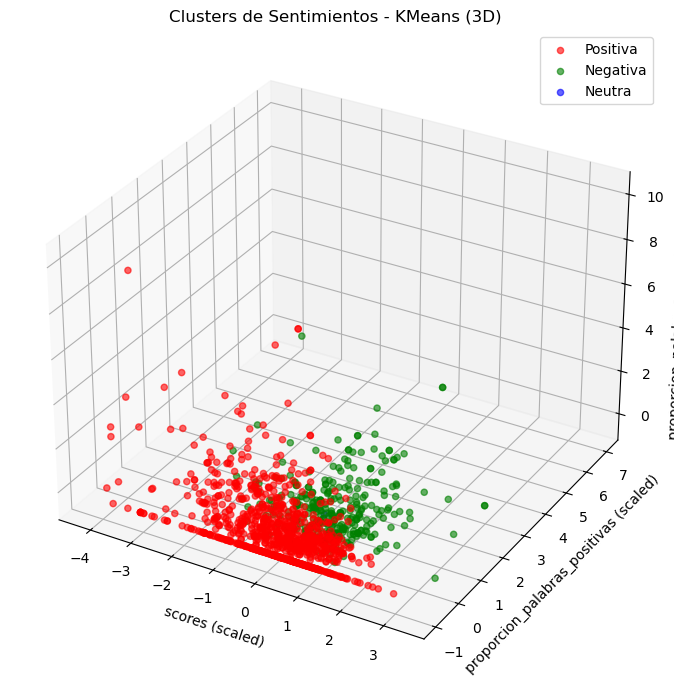

In [42]:

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Elegir tres características para la visualización
x = X_scaled[:, feature_columns.index('scores')]
y = X_scaled[:, feature_columns.index('proporcion_palabras_positivas')]
z = X_scaled[:, feature_columns.index('proporcion_palabras_negativas')]

# Colores por cluster
colors = ['red', 'green', 'blue']
for cluster in range(n_clusters):
    idx = cluster_labels == cluster
    ax.scatter(x[idx], y[idx], z[idx], c=colors[cluster], label=cluster_mapping[cluster], alpha=0.6)

ax.set_xlabel('scores (scaled)')
ax.set_ylabel('proporcion_palabras_positivas (scaled)')
ax.set_zlabel('proporcion_palabras_negativas (scaled)')
ax.set_title('Clusters de Sentimientos - KMeans (3D)')
ax.legend()
plt.tight_layout()
plt.show()



#### 7. Guardar en nuevo archivo

In [35]:

dataframe.to_csv('archivos/sentiment_scores_clustered.csv', index=False)